# Quantum Generative Adversarial Network (qGAN)

We would like to offer an alternative to previous approach by using some well known machine learning techniques applied to quantum regime. In this particular case we would like to explore the creation of a qGAN for the undertainty model on the option pricing. This approach was proposed by [Zoufal et al.](https://www.nature.com/articles/s41534-019-0223-2) and is divided into to main pieces.

The Generator, in this case a quantum circuit, is responsible for creating a quantum state whose outcome is previously mentioned expression

$$
G_\theta |\psi\rangle_n = \sum_{0}^{2 -1} \sqrt{p_i}|i\rangle_n,
$$

where $|i\rangle_n$ represent the encoded data sample and $p_i$ is its sampling probability.

The Discriminator is a binary classifier trying to identify if provided data sample was artificially generated by our $G_\theta$ generator (fake) or a real sample (taken from the real data). By trainig opposing this two pieces we aim achieving a nash-equilibrium so that the generator ends up being the best possible ansatz representing the target distribution of our data.

Let's start by loading our original Binance dataset.

In [1]:
import pandas as pd

dataset = pd.read_csv("../../data/binance_data.csv")
# Lets pivot so that the date is the index and each assets presents its closing price
pivoted = dataset.pivot(index="Closing time", columns="Asset", values="Close")
pivoted

Asset,BNBBTC,ETHBTC,LTCBTC,NEOBTC,QTUMETH
Closing time,,,,,
1634860799999,0.007571,0.065148,0.003162,0.000723,0.003250
1634947199999,0.007896,0.065446,0.003146,0.000733,0.003225
1635033599999,0.007920,0.067997,0.003203,0.000730,0.003177
1635119999999,0.007817,0.067079,0.003130,0.000720,0.003188
1635206399999,0.007689,0.066897,0.003097,0.000706,0.003137
...,...,...,...,...,...
1666051199999,0.014099,0.068105,0.002652,0.000411,0.002053
1666137599999,0.014130,0.067806,0.002682,0.000409,0.002054
1666223999999,0.014218,0.067208,0.002664,0.000403,0.002011


We will choose a subset of available assets.

In [2]:
assets = ["BNBBTC","ETHBTC","LTCBTC"]

And trim initial and ending of our distribution before it gets discretized.

In [3]:
import numpy as np

# We convert the Dataframe into a numpy array
training_data = pivoted[assets].to_numpy()

# Define minimal and maximal values for the training data
min_bound = np.percentile(training_data, 5, axis=0)
max_bound = np.percentile(training_data, 95, axis=0)
bounds = []
for i, _ in enumerate(min_bound):
    bounds.append([min_bound[i], max_bound[i]])

We need to map our samples to discrete values. This means depending on the qubit resolution we choose, each sample will need to be placed on a discrete bin like before. By chosing a 3 qubit representation that means our data should fit into $2^3 = 8$ bins. This is something that need to be considered as it affects the resolution of our model.

In [4]:
from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate

# Determine data resolution for each dimension of the training data in terms
# of the number of qubits used to represent each data dimension.
data_dim = [3, 3, 3]

# Pre-processing, i.e., discretization of the data (gridding)
(training_data, grid_data, grid_elements, prob_data) = discretize_and_truncate(
    training_data,
    np.asarray(bounds),
    data_dim,
    return_data_grid_elements=True,
    return_prob=True,
    prob_non_zero=True,
)

We can check how generated data fits into our selected space ($2^{9}$).

In [5]:
assert 2**sum(data_dim) == len(grid_elements)

Text(0, 0.5, 'Counts')

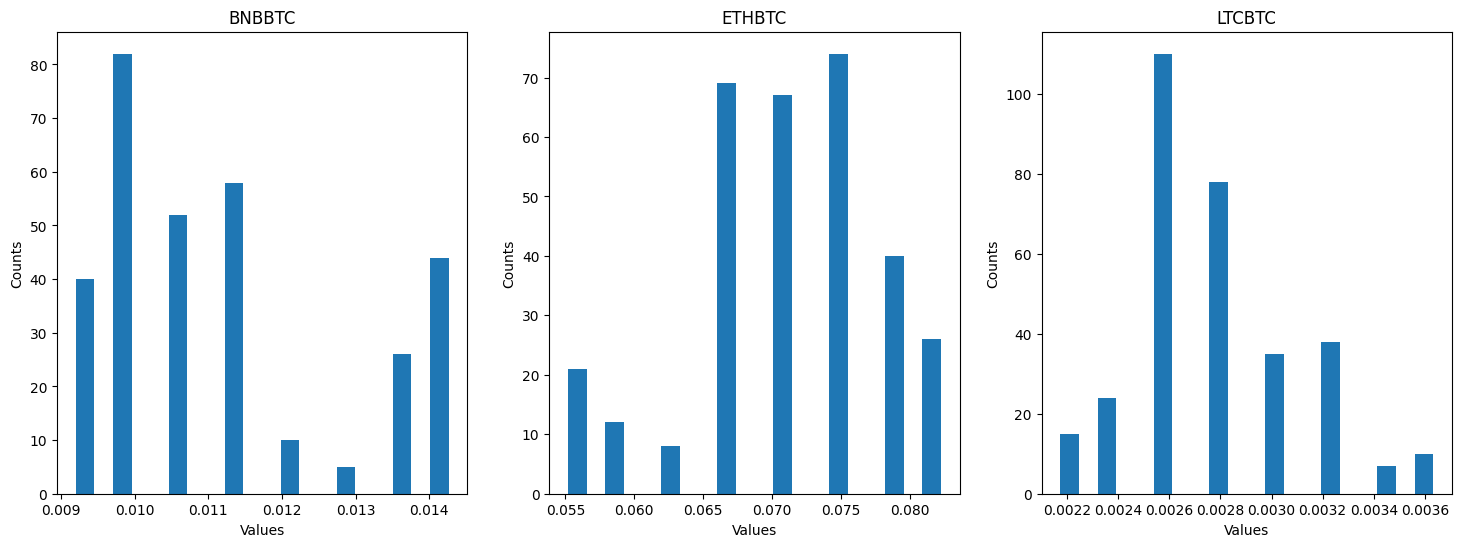

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.hist(training_data[:, 0], bins=20)
ax1.set_title(f"BNBBTC")
ax1.set_xlabel("Values")
ax1.set_ylabel("Counts")

ax2.hist(training_data[:, 1], bins=20)
ax2.set_title("ETHBTC")
ax2.set_xlabel("Values")
ax2.set_ylabel("Counts")

ax3.hist(training_data[:, 2], bins=20)
ax3.set_title("LTCBTC")
ax3.set_xlabel("Values")
ax3.set_ylabel("Counts")

This is the data and distribution to be replicated by our qGAN generator $G$.

The original paper used a secuence of $Y$ rotations parameterized per qubit as well as a cycle of $CZ$ gates entangling all qubits in a circular fashion (called entangling block). We will try to mimic a similar approach in Pennylane.

In [7]:
import torch
import pennylane as qml

def generator(weights, wires, repetitions):

    # Initial supperposition for all posible states
    for i in range(wires):
        qml.Hadamard(wires=i)

    k = 0 # carrying index
    for i in range(wires):
        qml.RY(weights[k], wires=i)
        k += 1

    # Repetition blocks
    for _ in range(repetitions):

        # Entangling block
        for i in range(wires-1):
            qml.CZ(wires=[i, i+1])
        # Last CZ turning to zero
        qml.CZ(wires=[wires-1, 0])

        # RY rotations
        for i in range(wires):
            qml.RY(weights[k], wires=i)
            k += 1

    return qml.probs(wires=range(qubits))

# Lets initialize the circuit
qubits = np.sum(data_dim)
dev = qml.device("default.qubit", wires=qubits)

# Also some parameters
layers = 1
params = [np.random.uniform(np.pi) for i in range(qubits + layers*qubits)]

gen_circuit = qml.QNode(generator, dev, interface='torch', diff_method='best')

(<Figure size 1500x1000 with 1 Axes>, <Axes: >)


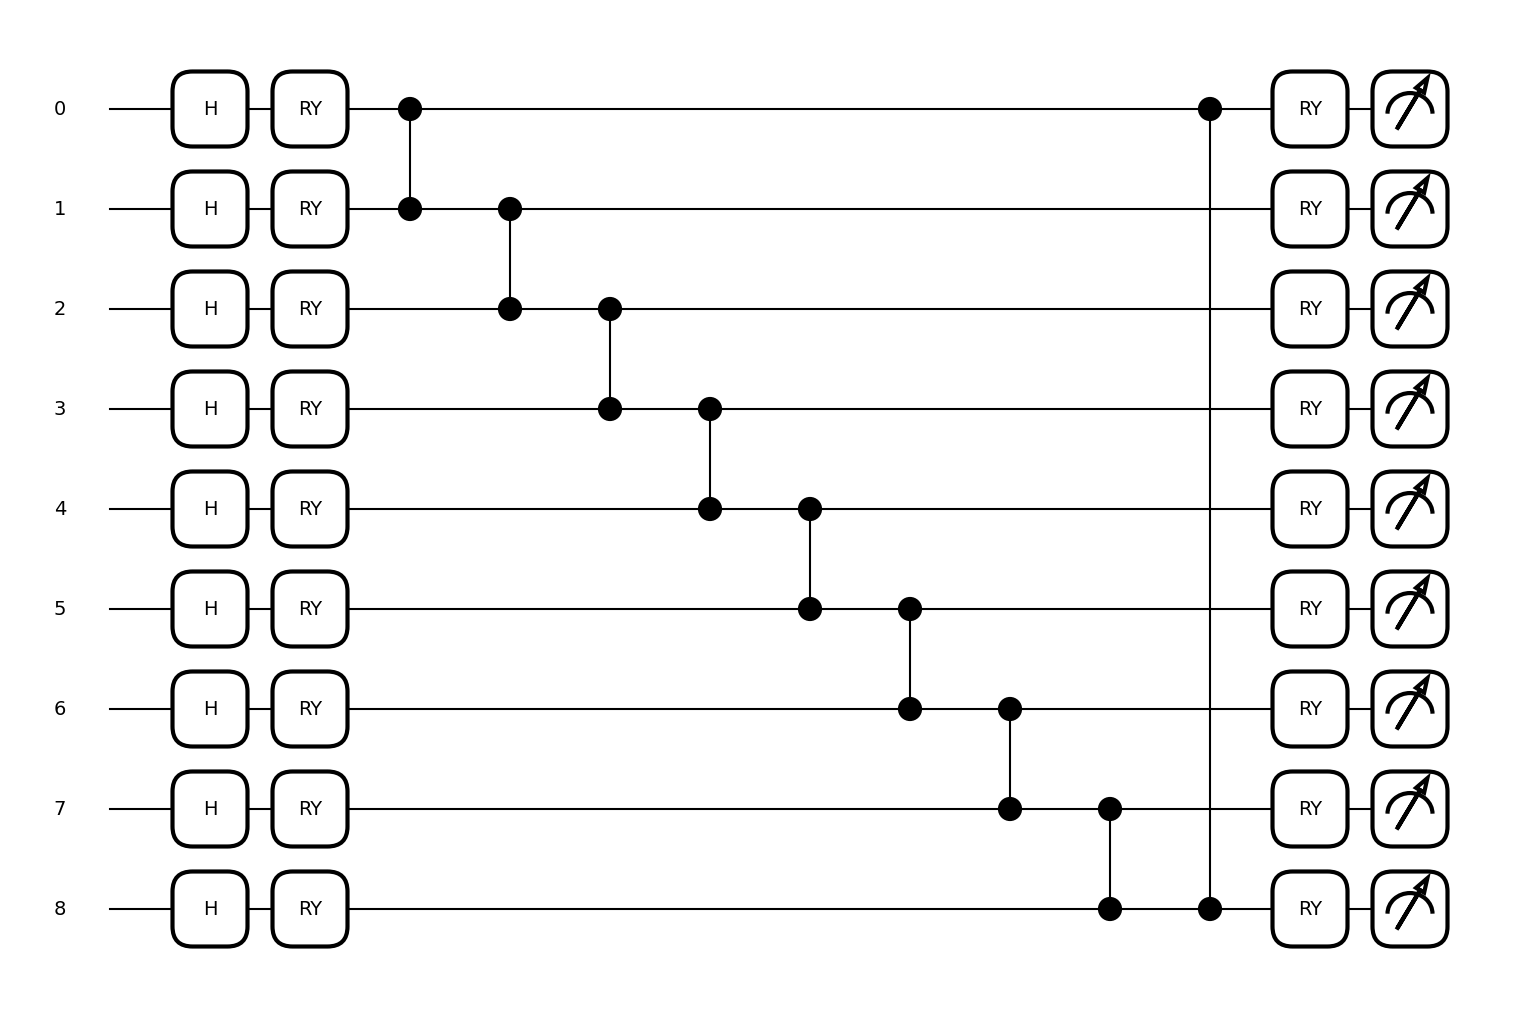

In [8]:
drawer = qml.draw_mpl(gen_circuit)
print(drawer(params, qubits, layers))

The Discrimantor piece can take many shapes, in our particular case we chose a classical Neural Network approach. Its output should ideally identify fake from real data as a binary classification.

In [9]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.lin_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.lin_input(input)
        x = self.leaky_relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

Now, with both elements designed we should select how we are going to train them so that we get a generator for option prices.

Given $m$ samples synthesized by the quantum generator ($g_i$ where $i = 1,...,m$) and $m$ samples taken from the real data ($x_i$ where $i = 1,...,m$) the loss function associated to both models can be described as follows.

$$

L_G(\phi, \theta) = - \frac{1}{m} \sum_{i=1}^{m} log D_\psi(g_i)

$$

$$

L_D(\phi, \theta) = - \frac{1}{m} \sum_{i=1}^{m} log D_\psi(x_i) + log(1 - D_\psi(g_i))

$$

Both loss functions refer to each other, that is how the nash-equilibrium is reached. Here, $\theta$ are Generator's parameters minimizing its loss and $\phi$ are Discriminator's.

For this example we will use the widelly known Adam optimizer (a gradient based optimization method).


In [14]:
from torch.optim import Adam

# Generator loss function
genloss_fun = nn.BCELoss()

# Discriminator loss function
discloss_fun = nn.BCELoss()

# Initialize generator and discriminator
disc_model = Discriminator(len(data_dim))

lr = 0.01  # learning rate
b1 = 0.9  # first momentum parameter
b2 = 0.999  # second momentum parameter
num_epochs = 20  # number of training epochs

# optimizer for the generator
optimizer_gen = qml.AdamOptimizer(stepsize=lr, beta1=b1, beta2=b2)

# optimizer for the discriminator
optimizer_disc = Adam(disc_model.parameters(), lr=lr, betas=(b1, b2))

In [15]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    training_data, 
    batch_size=300, 
    shuffle=True, 
    drop_last=True)

In [16]:
from IPython.display import clear_output

# Generator loss list
gen_loss_values = []
# Discriminator loss list
disc_loss_values = []

def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(gen_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ax = plt.subplots()

    # Loss
    ax.set_title("Loss")
    ax.plot(gen_loss_values, label="generator loss", color="royalblue")
    ax.plot(disc_loss_values, label="discriminator loss", color="magenta")
    ax.legend(loc="best")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.grid()

    plt.show()

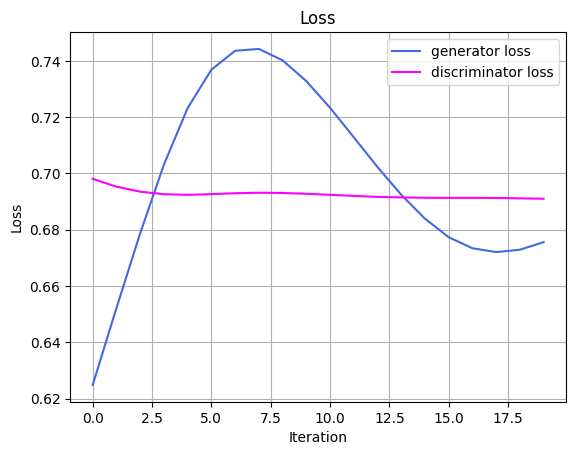

In [17]:
for epoch in range(num_epochs):
    generator_loss_epoch = []
    discriminator_loss_epoch = []
    theta = torch.tensor(params, dtype=torch.float32)
    for i, data in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.ones(data.size(0), 1)
        fake = torch.zeros(data.size(0), 1)

        # Generate a batch of data points
        fake_samples = []
        for _ in range(len(data)):
            probabilities = gen_circuit(theta, qubits, layers)
            gen_data = grid_elements[torch.argmax(probabilities)]
            fake_samples.append(gen_data)

        # Train Discriminator
        optimizer_disc.zero_grad()

        # Loss measures discriminator's ability to distinguish real from generated samples
        inputs = data.to(torch.float32)
        real_out = disc_model(inputs)
        real_loss = discloss_fun(real_out, valid)

        fake_input = torch.tensor(fake_samples, dtype=torch.float32)
        fake_out = disc_model(fake_input)
        fake_loss = discloss_fun(fake_out, fake)
        discriminator_loss = (real_loss + fake_loss) / 2

        discriminator_loss.backward(retain_graph=True)
        optimizer_disc.step()

        # Loss measures generator's ability to prepare good data samples
        fake_input = torch.tensor(fake_samples, dtype=torch.float32)
        fake_out = disc_model(fake_input)
        generator_loss = genloss_fun(fake_out, valid)
        returns, prev_cost = optimizer_gen.step_and_cost(gen_circuit, params, qubits, layers)
        params = returns[0]
        
        generator_loss_epoch.append(generator_loss.item())
        discriminator_loss_epoch.append(discriminator_loss.item())

    gen_loss_values.append(np.mean(generator_loss_epoch))
    disc_loss_values.append(np.mean(discriminator_loss_epoch))

    plot_training_progress()

Thanks to this now we have a generator that not only takes into consideration the singular evolution of an option, but also the correlated evolution of other market assets.